In [32]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [33]:
#### Preprocecing ###

In [34]:
Confirmed = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [35]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df

In [36]:
contries = confirmed.max() >= 1000
confirmed = confirmed.loc[:, contries]

In [37]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.loc[:, contries]


In [38]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.loc[:, contries]


In [39]:
removed = recovered + death

In [40]:
death['Korea, South']

2020-01-22      0
2020-01-23      0
2020-01-24      0
2020-01-25      0
2020-01-26      0
             ... 
2020-04-06    186
2020-04-07    192
2020-04-08    200
2020-04-09    204
2020-04-10    208
Name: Korea, South, Length: 80, dtype: int64

In [42]:
### Data Preparation ###

In [146]:
country = 'Korea, South'
S0 = confirmed[country].values
R0 = recovered[country].values
D0 = death[country].values
P = 5000_0000
repeat=10
iter=1000

In [147]:
data = {'T': S0.shape[0], 'P': P, 'S0': S0, 'R0': R0, 'D0': D0}

In [148]:
### Model ###

In [122]:
sm = pystan.StanModel(file="turzin.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6da476d0298607e9cc34c92760a973d8 NOW.


In [149]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=iter)

In [150]:
### Visualization functions ###

In [151]:
def extract_series(fit, name):
    value_list = []
    for d in range(S0.shape[0]):
        vals = fit['{}[{}]'.format(name, d+1)]
        value_list.append(vals)
    data = np.array(value_list)
    return pd.DataFrame(data, 
                        index=confirmed.index)

In [152]:
def draw(simulated, real=None):
    graph=pd.DataFrame()
    simulated = simulated.dropna(axis=1)
    median = simulated.median(axis=1)
    upper = simulated.quantile(q=0.75, axis=1)
    lower = simulated.quantile(q=0.25, axis=1)
    if not real is None:
        graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", data=graph, aspect=2)

In [153]:
S = extract_series(fit, 'S')

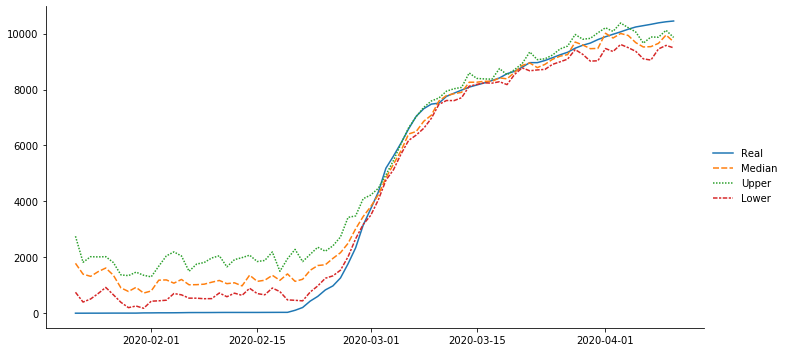

In [155]:
draw(fit['q'] * S, real=confirmed['Korea, South'])

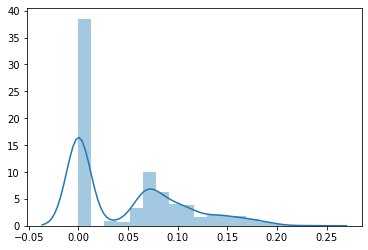

In [156]:
sns.distplot(fit['b'])

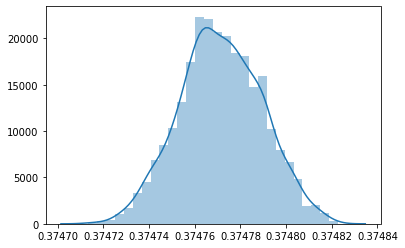

In [157]:
sns.distplot(fit['a'])

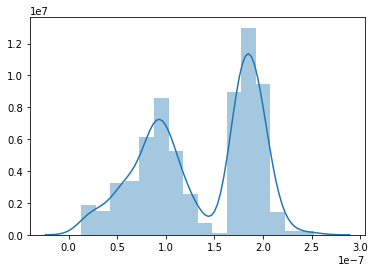

In [158]:
sns.distplot(fit['d'])

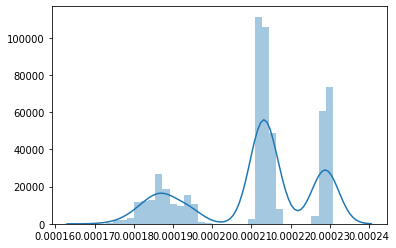

In [159]:
sns.distplot(fit['q'])

In [162]:
fit['q'].mean()*100

0.021073096142165088

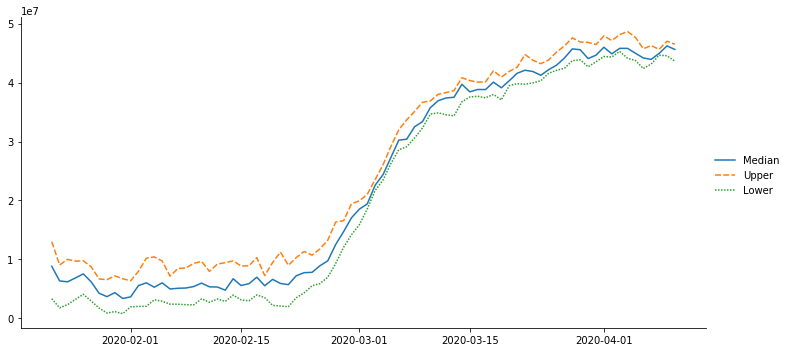

In [163]:
draw(S)

In [167]:
5*(10**7)

50000000